In [63]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.policy.policy import Policy
import ray

import gymnasium as gym
from rleplus.examples.bbright.env import BBrightEnv
from rleplus.examples.registry import register_all

import matplotlib.pyplot as plt
import numpy as np

In [16]:
# create the environment
env_config = {
    "csv": False,
    "verbose": False,
    "output": "./tmp/episodes-test/",
}

myenv = BBrightEnv(env_config)


/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [61]:
path = "./results/pmv_working/checkpoint/policies/default_policy"

# Use the `from_checkpoint` utility of the Policy class:
my_restored_policy = Policy.from_checkpoint(path)

# create previous states for the policy
# state = my_restored_policy.get_state()
# print('State:', type(state), state.keys())

state = my_restored_policy.get_initial_state()
print('State:', type(state), state.keys(), state['actor'].keys(), state['critic'].keys())

# creating observation-action pairs for the trained policy for sampled observations
obs_action_pairs = {'observations': [], 'actions': []}
verbose = False
for i in range(1000):
    # Sample an observation from the environment.
    obs = myenv.get_observation_space().sample()
    if verbose:
        print('Observation:', type(obs), obs)
    # obs = np.array([17.0, 17.0, 17.0, 50.0, 18.0, 18.5, 2e+05, 0.5, 17.5])
    # print('Observation:', type(obs), obs)

    # Use the restored policy for serving actions.
    output = my_restored_policy.compute_single_action(obs, state, unsquah_action=False)
    action = output[0][0]

    # Append the observation-action pair to the list.
    obs_action_pairs['observations'].append(obs)
    obs_action_pairs['actions'].append(action)
    if verbose:
        print('Action:', type(action), action)
print('Done', len(obs_action_pairs['observations']), len(obs_action_pairs['actions']))


State: <class 'dict'> dict_keys(['actor', 'critic']) dict_keys(['h', 'c']) dict_keys(['h', 'c'])


/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by 

Done 1000 1000


/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by 

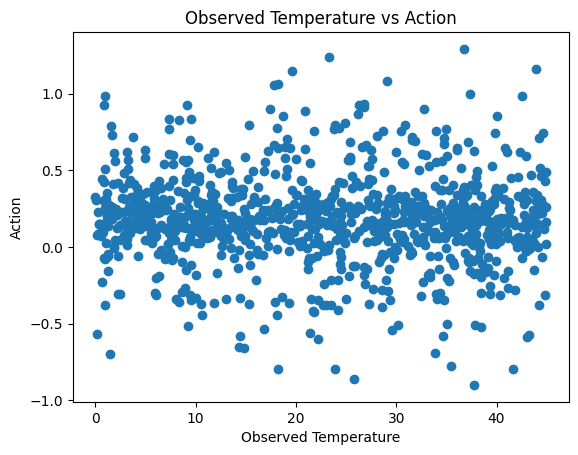

In [64]:
# plot the observations and action pairs in a scatter plot where the x-axis is the observation and the y-axis is the action

# Create data   
obs = np.array(obs_action_pairs['observations'])
acs = np.array(obs_action_pairs['actions'])

# plotting observed temperature vs action
plt.scatter(obs[:,1], acs)
plt.xlabel('Observed Temperature')
plt.ylabel('Action')
plt.title('Observed Temperature vs Action')
plt.show()


In [ ]:
# plot the observations and setpoint pairs in a scatter plot where the x-axis is the observation and the y-axis is the action

# Create data   
obs = np.array(obs_action_pairs['observations'])
acs = np.array(obs_action_pairs['actions'])

# plotting observed temperature vs action
plt.scatter(obs[:,1], acs)
plt.xlabel('Observed Temperature')
plt.ylabel('Action')
plt.title('Observed Temperature vs Action')
plt.show()

- configure env
- register env
- create custom loop
- import checkpoint model
- compute action according to obs

In [5]:
env_setup = {
    "env": "BBrightEnv",
    "csv": env_config["csv"],
    "verbose": env_config["verbose"],
    "output": env_config["output"],
    "num_workers": 1,
    "num_gpus": 0,
    "alg": "PPO",
    "use-lstm": True
}

config = (
    PPOConfig()
    .environment(
        env=env_setup["env"],
        env_config=env_setup,
    )
    .framework("torch")
    .training(
        gamma=0.95,
        lr=0.003,
        kl_coeff=0.3,
        train_batch_size=96,
        sgd_minibatch_size=96,
        vf_loss_coeff=0.01,
        use_critic=True,
        use_gae=True,
        model={
            "use_lstm": env_setup["use-lstm"],
            "vf_share_layers": False,
        },
        _enable_learner_api=True,
    )
    .rl_module(_enable_rl_module_api=True)
    .framework(
        # to use tensorflow, you'll need install it first,
        # then set framework="tf2" and eager_tracing=True (for fast exec)
        framework="torch",
    )
    .resources(num_gpus=env_setup["num_gpus"])
    .rollouts(
        num_rollout_workers=env_setup["num_workers"],
        rollout_fragment_length="auto",
    )
)

In [9]:
# store algorithm from checkpoint
ray.shutdown()
path = "./results/pmv_working/checkpoint"
ray.init()

register_all()

model = config.build()
model.restore(path)

# get the action distribution
actions = []
for i in range(96):
    action = model.compute_action(obs)

# plot the actions
plt.plot(actions)
plt.show()

ray.shutdown()

/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszVVEjS-py3.10/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/l4/.cache/pypoetry/virtualenvs/rl-energyplus-hi-YszV

EnvError: The env string you provided ('BBrightEnv') is:
a) Not a supported/installed environment.
b) Not a tune-registered environment creator.
c) Not a valid env class string.

Try one of the following:
a) For Atari support: `pip install gym[atari] autorom[accept-rom-license]`.
   For VizDoom support: Install VizDoom
   (https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md) and
   `pip install vizdoomgym`.
   For PyBullet support: `pip install pybullet`.
b) To register your custom env, do `from ray import tune;
   tune.register('[name]', lambda cfg: [return env obj from here using cfg])`.
   Then in your config, do `config['env'] = [name]`.
c) Make sure you provide a fully qualified classpath, e.g.:
   `ray.rllib.examples.env.repeat_after_me_env.RepeatAfterMeEnv`
